In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show, ion
import matplotlib.image as mpimg
import cv2
import scipy.io
from tqdm import tqdm

# from scipy.stats import ortho_group
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
from LDMIBSS import *
from numba import njit
import warnings
warnings.filterwarnings("ignore")
np.random.seed(250)

In [2]:
def Subplot_RGB_images(I, imsize = [3240, 4320], height = 15, width = 15, title = ''):
    n_images = I.shape[0]
    Im = [I[i,:].reshape(imsize[0],imsize[1],3) for i in range(I.shape[0])]
    fig, ax = plt.subplots(1,n_images, figsize = (25,50))
    fig.suptitle(title)
    fig.set_figheight(height)
    fig.set_figwidth(width)   
    for i in range(n_images):
        ax[i].imshow(Im[i])
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)
    plt.subplots_adjust(right=0.97,\
                    left=0.03,\
                    bottom=0.03,\
                    top=0.97,\
                    wspace=0.1,\
                    hspace=0.1)
    plt.draw()    

In [3]:
os.chdir("..")
os.chdir("./NumericalExperiments/ImageSeparation")
image_paths = 'TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [4]:
small_images = np.zeros((images.shape[0],324* 432* 3))
small_to_large_image_size_ratio = 0.1
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    if small_img.shape[0] == 302:
        small_img = cv2.resize(small_img, (0,0), fx = 432/403, fy = 324/302)
    print(small_img.shape)
    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)


(4, 419904)

<IPython.core.display.Math object>

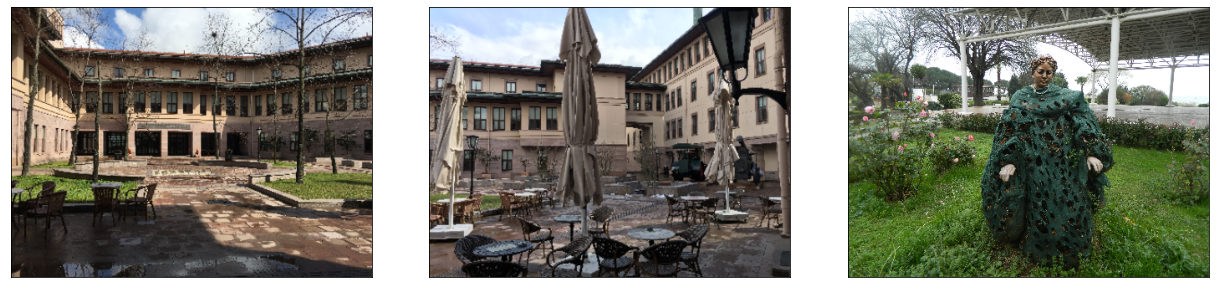

In [5]:
S = small_images[[2,0,1]]
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [6]:
np.random.seed(50)
NumberofMixtures = 5
NumberofSources = 3
# S_ = 2 * S - 1
INPUT_STD = 0.28
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
# A = np.random.uniform(size=(NumberofMixtures,NumberofSources))
X = A @ S
for M in range(A.shape[0]):
    stdx = np.std(X[M,:])
    A[M,:] = A[M,:]/stdx * INPUT_STD
    
SNR=40
# A = np.abs(A)
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp

print(20*np.log10(np.std(Xn)/np.std(Noisecomp)))

X_ = ZeroOneNormalizeColumns(X.T).T
print('The following is the mixture matrix')
display_matrix(A)

41.122659361820595
The following is the mixture matrix


<IPython.core.display.Math object>

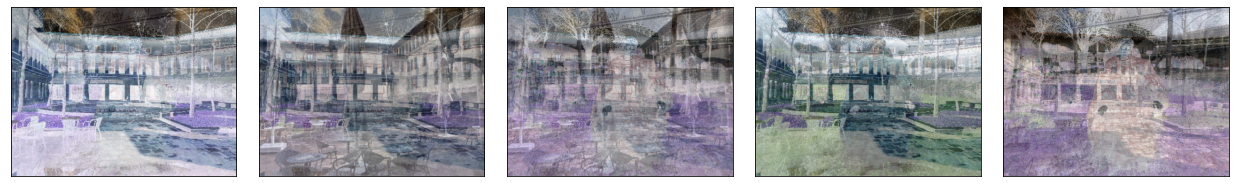

In [7]:
Subplot_RGB_images(X_, imsize = [324,432], height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

# LDMIBSS

In [17]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 2000
model = MinibatchLDMIBSS(s_dim = s_dim, x_dim = x_dim,
                     set_ground_truth = True, S = S, A = A)

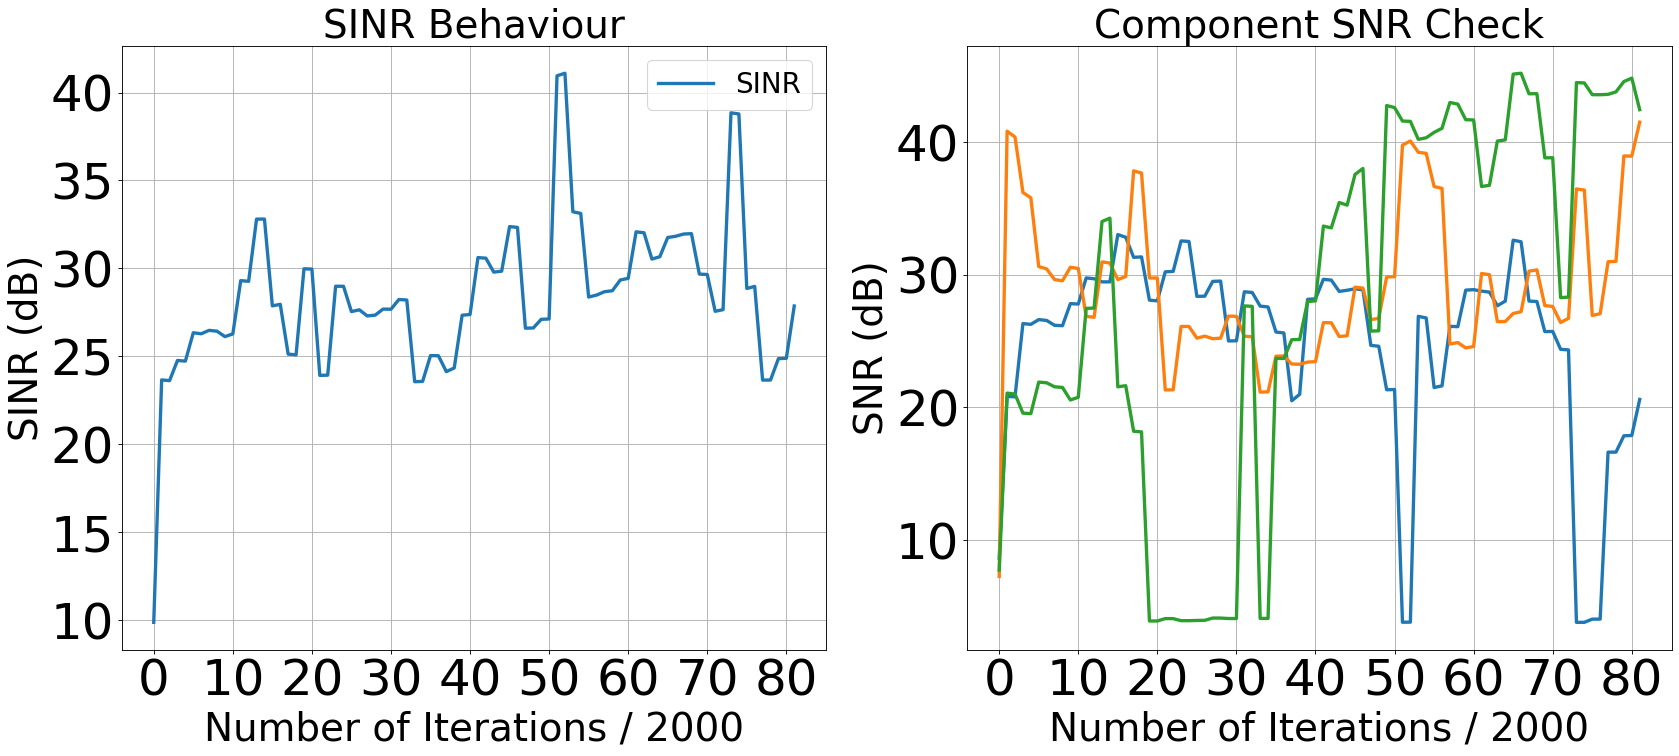

100%|██████████| 2000/2000 [00:04<00:00, 476.75it/s]


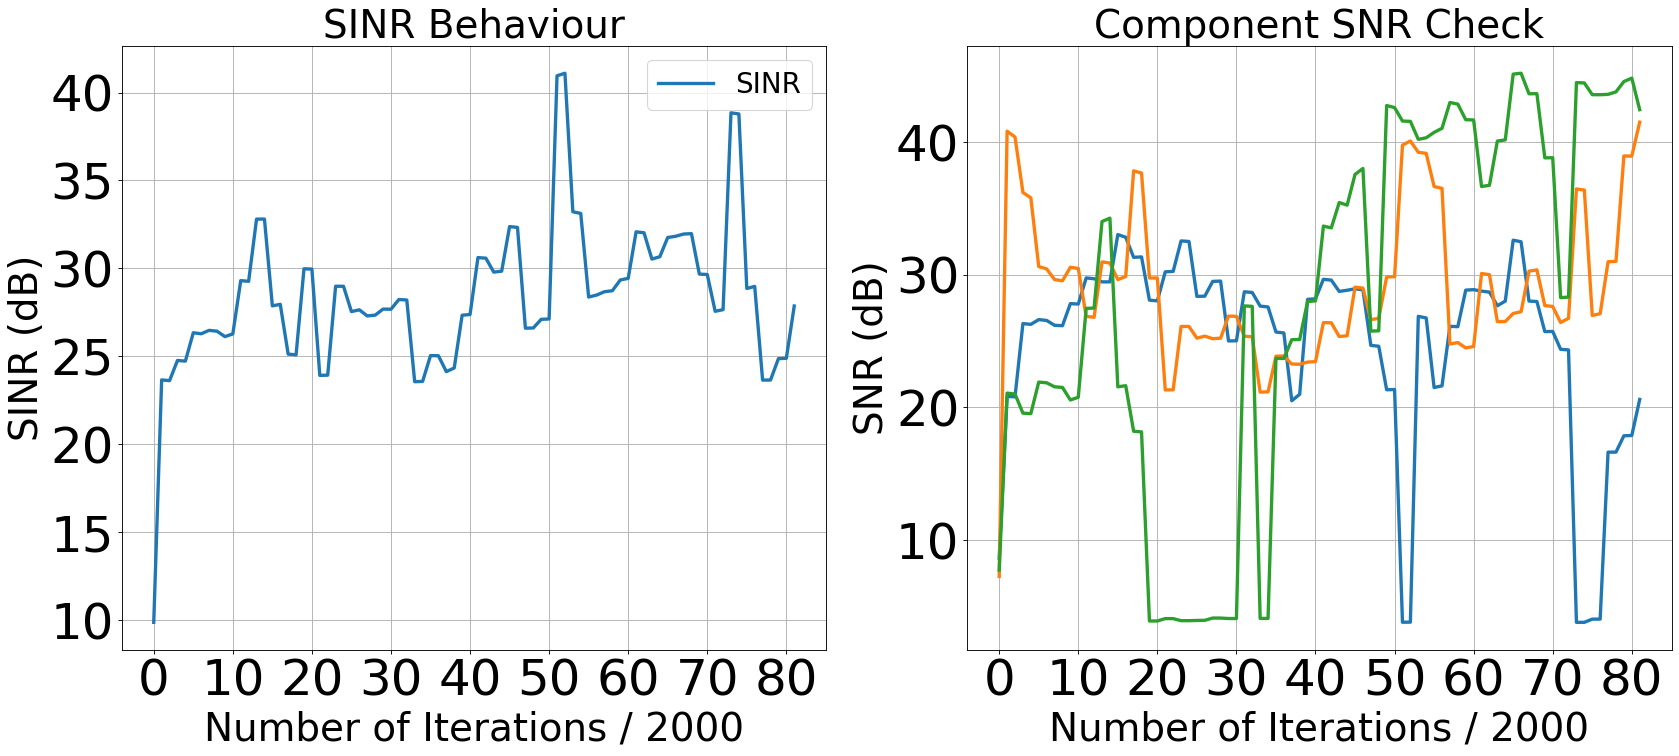

In [18]:
model.fit_batch_nnantisparse(X, batch_size = 10000, epsilon = 1e-5, mu_start = 100, 
                             n_iterations_per_batch = 2000, method = "covariance", 
                             debug_iteration_point = debug_iteration_point,
                             plot_in_jupyter = True)

In [12]:
W = model.W
Y = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
10 * np.log10(CalculateSINR(Y_.T, S)[0])

9.52776384313846

In [13]:
W = model.W
Y_ = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
snr(S.T, Y_)

array([7.67204056, 8.89625409, 7.4168143 ])

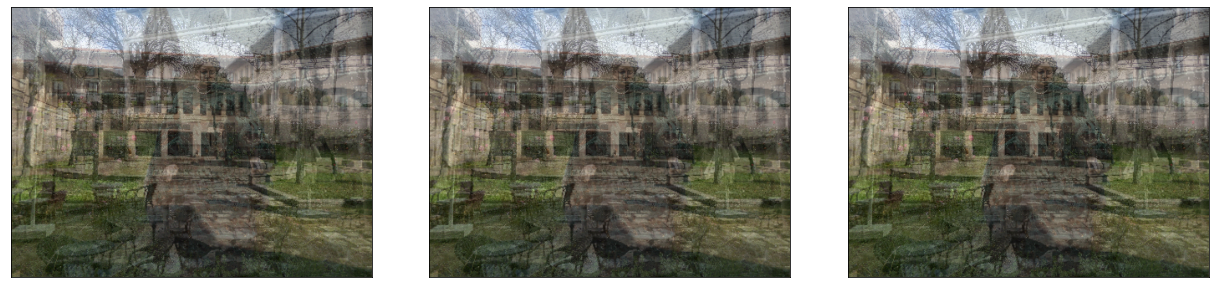

In [14]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_).T, imsize = [324,432], height = 4, width = 18)
# plt.savefig('NSM_nowhitening_Output.pdf', format = 'pdf', dpi = 1500)

# ICA

In [20]:
import mne
from mne.preprocessing import ICA

In [21]:
#######################################################
#                 ICA INFOMAX                         #
#######################################################
mneinfo=mne.create_info(NumberofMixtures,2000,ch_types=["eeg"]*NumberofMixtures)
mneobj=mne.io.RawArray(X,mneinfo)
ica = mne.preprocessing.ICA(n_components=NumberofSources, method="infomax",
                    fit_params={"extended": True, "n_subgauss":NumberofSources,"max_iter":10000},
                    random_state=1,verbose=True)
ica.fit(mneobj)
#SINR,SigPow,MSE,G=CalculateSINR(o,S)
Se = ica.get_sources(mneobj)
o = Se.get_data()
SINR, SigPow, MSE, G = CalculateSINR(o, S)

Creating RawArray with float64 data, n_channels=5, n_times=419904
    Range : 0 ... 419903 =      0.000 ...   209.952 secs
Ready.
Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 3 components
Computing Extended Infomax ICA
Fitting ICA took 39.6s.


In [22]:
Y_ = signed_and_permutation_corrected_sources(S.T,o.T)

In [23]:
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
snr(S.T, Y_)

array([1.08505548, 1.32620294, 1.15548783])

In [24]:
Y_.shape

(419904, 3)

In [25]:
Y_ = signed_and_permutation_corrected_sources(S.T,o.T)
Y_ = ZeroOneNormalizeColumns(Y_)
snr(S.T, Y_)

array([ 7.79691946, 11.95289472,  9.1999294 ])

In [26]:
10*np.log10(CalculateSINR(Y_.T, S)[0])

13.928695792217365

In [ ]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_).T, imsize = [324,432], height = 4, width = 18)
# plt.savefig('ICAOutput.pdf', format = 'pdf', dpi = 1500)